# Когнитивные технологии

*Алла Тамбовцева, НИУ ВШЭ*

## Множественная регрессия и тестирование качества модели

Продолжим работать с таблицей, содержащие данные по преподавателям и их заработной плате:

In [1]:
import pandas as pd
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Salaries.csv")

In [2]:
# опять переименуем столбцы с точкой
cols = list(df.columns)
cols[3], cols[4] = 'phd', 'service'
df.columns = cols

Импортируем функцию `ols`:

In [3]:
from statsmodels.formula.api import ols 

Построим модель, где зависимой переменной является заработная плата, а независимыми – число лет опыта работа и число лет после получения степени. Учтём обе независимые переменные в модели (константа всегда добавляется по умолчанию):

In [4]:
model1 = ols('salary ~ service + phd', df).fit()

Посмотрим на результаты:

In [5]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     45.71
Date:                Mon, 31 Dec 2018   Prob (F-statistic):           1.40e-18
Time:                        21:44:51   Log-Likelihood:                -4617.9
No. Observations:                 397   AIC:                             9242.
Df Residuals:                     394   BIC:                             9254.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.991e+04   2843.560     31.620      0.0

По значениям в столбце `P>|t|` видно, что оба коэффициента при предикторах являются статистически значимыми на уровне значимости 5%, гипотеза о равенстве коэффициентов нулю отвергается. То же показывает и p-value для `F-statistic`. Запишем уравнение модели на основе полученных результатов (коэффициенты округлены):

$$
salary = 89910 - 629 \cdot service + 1563 \cdot phd
$$

В отличие от модели парной регрессии, здесь коэффициент при `service` уже отрицательный. Получается, что число лет опыта работы негативно сказывается на заработной плате! С одной стороны, это кажется контринтуитивным, но с другой стороны, вполне может оказаться, что другой фактор, включённый в модель, `phd` является более значимым и в сочетании с `service` «оттягивает» значимость на себя. Давайте внимательно посмотрим на уравнение модели.

В проигрыше те преподаватели, которые имеют большой опыт работы, но при этом недавно получили степень. Ситуация достаточно логичная; можно предположить, что если заработная плата зависит от научных достижений, то сотрудники, работающие давно и при этом не стремящиеся как можно скорее получить научную степень, защитить диссертацию и писать статьи, получают меньшую заработную плату. Здесь мы рискуем задуматься и отдалиться от регрессионной модели, поэтому давайте вернёмся к таблице. 

Качество модели, если мы оцениваем его по значению коэффициента детерминации $R^2$, не кажется высоким, особенно, учитывая, что это довольно стандартная модель, поэтому $R^2$ в данном случае можно свободно интерпретировать как долю дисперсии заработной платы, объяснённую моделью (предикторами «опыт работы» и «число лет после получения степени»). Самое время проверить другие показатели качества модели. Из уже имеющихся в таблице показателей, в частности, из p-value для значения F-статистики, можем заключить, что модель нужна: гипотеза о равенстве всех коэффициентов регресии нулю отвергается. 

Какие аспекты в приведённой выше таблицы не учтены? Во-первых, проверка модели на наличие потенциальных проблем, возникающих во множественной регрессии. 

### Мультиколлинеарность 

Первая проблема – *мультиколлинеарность*, сильная линейная связь между предикторами. К чему эта проблема может привести? К неверным выводам о значимости коэффициентов регрессии, которые следуют из слишком «раздутых» стандартных ошибок коэффициентов, имеющих место при мультиколлинеарности. Как распознать мультиколлинеарность в модели? Рассмотрим некоторые признаки.

1. Высокие значения коэффициента линейной корреляции между предикторами. 
2. Высокий коэффициент детерминации $R^2$ при большой доле незначимых коэффициентов при предикторах.
3. Высокие (больше $5$) значения показателя [VIF](https://en.wikipedia.org/wiki/Variance_inflation_factor) (*variance inflation factor*) для независимых переменных или среднее значение всех VIF больше $5$ (в крайнем случае больше $10$).

Пожалуй, самый однозначный результат можно получить, воспользовавшись последним способом. Однако посмотрим и на первые два. Второй способ сразу исключим, поскольку в нашем случае высокого $R^2$ и незначимых предикторов не наблюдается. Для проверки первым способом посчитаем коэффициент корреляции Пирсона между двумя предикторами в модели:

Для вычисления VIF я позволила себе воспользоваться готовой функцией со *stackoverflow*, чтобы вывести значения VIF для всех переменных сразу. Встроенная в `statsmodels` функция `variance_inflation_factor()` расчитывает значения VIF для конкретных переменных и при этом исключает из модели константу, что отражается на результатах (они отличаются от привычных значений VIF, которые обычно используются и интерпретируются в эконометрике).

In [6]:
# взято с https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [7]:
variance_inflation_factors(df[['service', 'phd']])

const      4.289177
service    5.795810
phd        5.795810
Name: VIF, dtype: float64

По значениям VIF видно, что они превышают принятое пороговое значение $5$, но несильно. Можно считать, что данная модель не страдает от мультиколлинеарности. Тем не менее, давайте обсудим, как с этой проблемой бороться. Итак, *методы борьбы с мультиколлинеарностью*:

1. Исключить предиктор с наибольшим VIF из модели, если это позволяют содержательные соображения (например, если предиктор явно дублирует информацию, содержащуюся в других переменных в модели).
2. «Схлопнуть» сильно связанные предикторы в одну переменную, используя метод главных компонент и включить полученный интегральный индикатор в качестве предиктора модели (один вместо группы схожих между собой).
3. Использовать методы регуляризации модели (техники схожи с методами борьбы с переобучением линейной модели в машинном обучении).

### Гетероскедастичность

Вторая возможная проблема – *гетероскедастичность* – непостоянство дисперсии остатков. Одно из допущений линейной модели (одно из [условий](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%93%D0%B0%D1%83%D1%81%D1%81%D0%B0_%E2%80%94_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B0) Гаусса-Маркова) – постоянство дисперсии остатков/ошибок модели, то есть $D(\varepsilon_i) = const$ для всех $i$. Чтобы распознать гетероскедастичность в модели, можно воспользоваться специальным тестом. Однако обычно рекомендуется думать об источниках гетероскедастичности заранее, если их по содержательным соображениям быть не должно, то не стоит слепо доверять результатам тестов на гетероскедастичность, так как они могут работать нестабильно, зависеть от числа наблюдений в выборке и структуры данных.

Рассмотрим тест Бройша-Пагана, один из популярных тестов на гетероскедастичность. Нулевая гипотеза, проверяемая с помощью этого теста – дисперсия остатков модели постоянна:

$H_0: D(\varepsilon_i) = D(\varepsilon_j) = \sigma^2$ для всех $i \ne j$ (гомоскедастичность).

Применим тест к нашей модели.

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan

Функция `het_breuschpagan` из `statsmodels` принимает на вход остатки модели и набор независимых переменных.

In [9]:
het_breuschpagan(model1.resid, df[['phd', 'service']])

(149.44370609921543,
 2.293790755993904e-34,
 119.22594044982796,
 3.0866291683237355e-41)

Этот тест выводит значения F-статистики и p-value для каждой переменной. Значения p-value в нашем случае близки к нулю, поэтому чисто формально гипотезу о гомоскедастичности следует отвергнуть. Как справляться с гетероскедастичностью в модели? Обычно выбирают другой тип стандартных ошибок коэффициентов, устойчивый к гетероскедастичности (*heteroskedasticity consistent* или точнее *Huber–White standard errors* или *White standard errors*). Такие ошибки ещё часто называют робастными, однако робастность – это более общее свойство, относящееся к различным типам скорректированных ошибок (устойчивые к гетероскедастичности, к автокорреляции, к возмущениям в модели, к наличию различий по группам наблюдений).

Есть несколько подтипов ошибок, устойчивых к гетероскедастичности, на практике часто используют 2 типа: *hc0* (для больших выборок) и *hc3* (для маленьких выборок). 

Учесть тип ошибок модели можно при оценке модели, указав их в качестве аргумента методв `.fit()`. 

In [10]:
model_hc = ols('salary ~ service + phd', df).fit(cov_type='hc3')

In [11]:
print(model_hc.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     38.02
Date:                Mon, 31 Dec 2018   Prob (F-statistic):           7.96e-16
Time:                        21:44:51   Log-Likelihood:                -4617.9
No. Observations:                 397   AIC:                             9242.
Df Residuals:                     394   BIC:                             9254.
Df Model:                           2                                         
Covariance Type:                  hc3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.991e+04   2440.680     36.839      0.0

Теперь мы видим, что тип ошибок выбран другой, и это указано в параметрах модели (`Covariance Type`). Значения коэффициентов не отличаются от значений в предыдущей модели, но вот стандартные ошибки изменились, и, соответственно, значимость тоже (и распределение статистики критерия для проверки гипотезы о значимости коэффициент уже не Стьюдента, а стандартное нормальное). К выбору типа ошибок стоит относиться внимательно, поскольку изменение типа стандартных ошибок ведёт к изменению p-value и выводов относительно нулевой гипотезы. 

### Влиятельные наблюдения в модели

Ещё одна проблема, которая может отразиться на качестве модели и на выводах относительно значимости коэффициентов, – это наличие влиятельных наблюдений. Про нетипичные наблюдения (выбросы, *outliers*), вы уже, скорее всего знаете, это просто значения, сильно отклоняющиеся от среднего и медианы. Формально границы типичных значений в выборке определяются как $[Q1-1.5\Delta; Q3+1.5\Delta]$, где $Q_1$ и $Q_3$ – нижний и верхний квартили, а $\Delta$ – межквартильный размах ($Q3-Q1$). [Влиятельные наблюдения](https://en.wikipedia.org/wiki/Influential_observation) – наблюдения в данных, которые влияют на расположение регрессионной прямой или гиперплоскости. Если рассмотрим случай парной регрессии, то при удалении влиятельного наблюдения наклон прямой может радикально измениться, коэффициент может даже сменить знак. Это плохо, потому что устойчивая модель, которая даёт стабильные результаты, не должна зависеть от таких локальных изменений. Влиятельные наблюдения часто удаляют из данных, а затем оценивают модель заново.

Один из распространённых методов выявления влиятельных наблюдений – оценить [меру Кука](https://en.wikipedia.org/wiki/Cook%27s_distance) (расстояние Кука, *Cook's distance*) для каждого наблюдения. Пороговое значение меры Кука, превышение которого свидетельствует о влиятельности наблюдения,  равно $\frac{4}{n-p-1}$, где $n$ – число наблюдений, $p$ – число предикторов. В нашем случае $\frac{4}{397-2-1} \approx 0.01$. Посмотрим на значения меры Кука для наблюдений в нашей модели:

In [12]:
from statsmodels.stats import outliers_influence
influence = outliers_influence.OLSInfluence(model_hc)

In [13]:
cookd = influence.cooks_distance[0]
cookd

array([1.64522825e-03, 4.52821510e-03, 7.67725627e-04, 2.02234416e-03,
       1.17868559e-03, 7.52446855e-06, 4.55331291e-03, 1.61554561e-03,
       1.36027966e-04, 9.89635971e-04, 4.85722212e-04, 1.11238278e-03,
       7.99906728e-04, 9.11209131e-04, 3.59013882e-05, 3.11851393e-04,
       8.55457751e-05, 1.78278233e-03, 3.79453042e-04, 2.63923502e-04,
       1.73787282e-03, 1.41803049e-03, 1.99192957e-03, 6.61574087e-06,
       1.62937397e-03, 5.10666541e-04, 8.50739797e-05, 5.91093845e-04,
       3.69253049e-03, 3.95579366e-04, 1.18950521e-03, 1.09938318e-03,
       2.77360944e-04, 7.54966568e-04, 7.54966568e-04, 1.42389639e-03,
       3.30179480e-03, 3.93764330e-04, 3.54699179e-04, 1.96625028e-05,
       5.70147560e-03, 6.50747773e-04, 6.02095482e-03, 4.78629948e-02,
       3.46789441e-04, 4.97417002e-05, 6.24085034e-03, 1.65294493e-03,
       1.52975151e-03, 1.86592263e-03, 2.67178142e-04, 1.10646886e-04,
       2.52500332e-03, 1.17213009e-05, 8.82618650e-06, 1.57735851e-03,
      

Посмотрим, если ли влиятельные наблюдения:

In [14]:
cookd[cookd > 0.01]

array([0.04786299, 0.03596405, 0.05108295, 0.01453276, 0.01992538,
       0.01315596, 0.01137607, 0.01783529, 0.06927546, 0.01258102,
       0.04343557, 0.05692139, 0.02336134, 0.02731767, 0.0419529 ,
       0.02767228, 0.01993124, 0.01050145, 0.02748002, 0.08013882,
       0.01493802, 0.01741107, 0.03265774, 0.0169958 , 0.01226352])

Такие есть и, в принципе, можно определить индексы таких наблюдений и удалить их. Однако давайте посмотрим на график, который обычно используется для визуализации нетипичных и влиятельных наблюдений, и примем окончательное решение. По оси абсцисс в таком графике указано значение влиятельности (*leverage*), а по оси ординат – стьюдентизированные остатки модели, которые показывают нетипичность наблюдений. Тип графика – пузырьковая диаграмма (*bubble plot*), диаграмма рассеяния с точками различного размера. Величина точки изменяется пропорционально мере Кука, чем больше мера Кука, тем больше точка. 

In [15]:
from statsmodels.api import graphics
from matplotlib import pyplot as plt

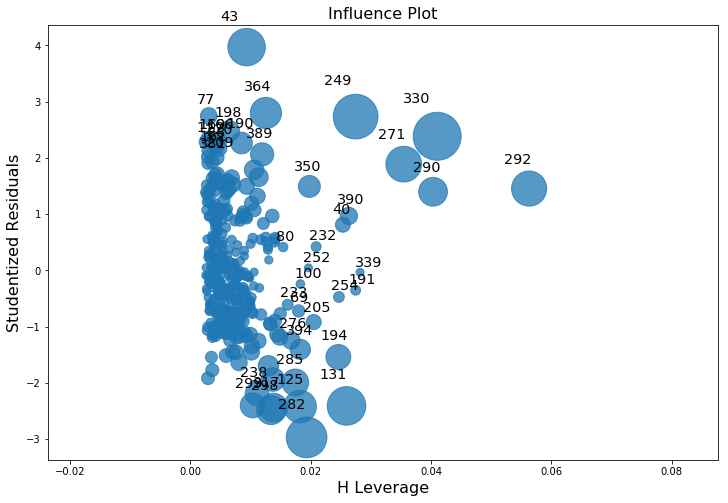

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = graphics.influence_plot(model1, ax=ax, criterion="cooks")

График не очень красивый для демонстрации, но из него можно вынести много полезной информации. Обычно из массива данных для построения регрессии удаляют не все значения с высокой влиятельностью, а те, которые являются и нетипичными, и влиятельными одновременно. На графике выше это те точки, которые лежат в правом верхнем углу. Решение об удалении влиятельных наблюдений обычно субъективно, зависит от исследователя. В данном случае очень нетипичными и влиятельными наблюдениями являются наблюдения с индексами 271, 290, 292 и 330. В дальнейшем их желательно удалить и переоценить модель.

Так как документация у библиотеки `statsmodels` не очень интуитивная, в качестве дополнения предлагаю найденные ноутбуки по соответствующим темам: [1](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html), [2](http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/en_Tanagra_Python_StatsModels.pdf).